In [1]:
import os
import json
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.utils import resample
from uuid import uuid4
from tqdm import tqdm
from typing import Dict, List, Optional
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns

In [2]:
def load_json(json_file_path):
    print(f"Loading JSON file from {json_file_path}")
    with open(json_file_path, 'r') as f:
        return json.load(f)

In [3]:
def calculate_metrics(predictions_df, save_confusion_matrix=True, output_dir="../data"):
    """
    Calculate precision, accuracy, recall, F1-score, and confusion matrix.
    
    Args:
        predictions_df: DataFrame with 'true_species' and 'predicted_species' columns
        save_confusion_matrix: Whether to save confusion matrix plot
        output_dir: Directory to save confusion matrix plot
    
    Returns:
        Dictionary with all metrics
    """
    # Remove rows with failed predictions
    df_valid = predictions_df[predictions_df['predicted_species'].notna()].copy()
    
    if len(df_valid) == 0:
        print("❌ No valid predictions found!")
        return None
    
    y_true = df_valid['true_species']
    y_pred = df_valid['predicted_species']
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Calculate per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # Get unique classes
    classes = sorted(y_true.unique())
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # Print results
    print("=" * 60)
    print("OVERALL METRICS")
    print("=" * 60)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy:.2%})")
    print(f"Precision: {precision:.4f} ({precision:.2%})")
    print(f"Recall:    {recall:.4f} ({recall:.2%})")
    print(f"F1-Score:  {f1:.4f} ({f1:.2%})")
    print(f"\nTotal samples: {len(df_valid)}")
    print(f"Failed predictions: {len(predictions_df) - len(df_valid)}")
    
    print("\n" + "=" * 60)
    print("PER-CLASS METRICS")
    print("=" * 60)
    
    # Create per-class metrics DataFrame
    per_class_metrics = pd.DataFrame({
        'Species': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'Support': [sum(y_true == c) for c in classes]
    })
    print(per_class_metrics.to_string(index=False))
    
    # Plot confusion matrix
    if save_confusion_matrix:
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=classes, yticklabels=classes,
                    cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix', fontsize=16, pad=20)
        plt.xlabel('Predicted Species', fontsize=12)
        plt.ylabel('True Species', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        # Save plot
        cm_path = os.path.join(output_dir, 'confusion_matrix.png')
        plt.savefig(cm_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Confusion matrix saved to: {cm_path}")
        plt.show()
    
    # Return metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'per_class_metrics': per_class_metrics,
        'classes': classes,
        'n_samples': len(df_valid),
        'n_failed': len(predictions_df) - len(df_valid)
    }
    
    return metrics

Load Predictions and Calculate Metrics

In [4]:
# Load predictions from CSV
predictions_df = pd.read_csv("../data/predictions_test.csv")

# Display first few rows
print("Predictions DataFrame:")
predictions_df.head()

Predictions DataFrame:


,image_path,image_id,true_species,predicted_species,confidence,vote_counts,correct
0,../data/serengeti/images/S4_T12_R2_IMAG1234.JPG,S4/T12/T12_R2/S4_T12_R2_IMAG1234,zebra,zebra,1.0,{'zebra': 5},True
1,../data/serengeti/images/S6_B07_R2_IMAG0070.JPG,S6/B07/B07_R2/S6_B07_R2_IMAG0070,zebra,zebra,1.0,{'zebra': 5},True
2,../data/serengeti/images/S4_C13_R1_IMAG1852.JPG,S4/C13/C13_R1/S4_C13_R1_IMAG1852,zebra,buffalo,0.6,"{'buffalo': 3, 'zebra': 2}",False
3,../data/serengeti/images/S2_C04_R3_IMAG1412.JPG,S2/C04/C04_R3/S2_C04_R3_IMAG1412,zebra,zebra,1.0,{'zebra': 5},True
4,../data/serengeti/images/S2_G01_R1_PICT0873.JPG,S2/G01/G01_R1/S2_G01_R1_PICT0873,zebra,zebra,1.0,{'zebra': 5},True


OVERALL METRICS
Accuracy:  0.6992 (69.92%)
Precision: 0.7894 (78.94%)
Recall:    0.6992 (69.92%)
F1-Score:  0.7103 (71.03%)

Total samples: 1200
Failed predictions: 0

PER-CLASS METRICS
     Species  Precision  Recall  F1-Score  Support
      baboon   1.000000    0.52  0.684211      100
     buffalo   0.650407    0.80  0.717489      100
     cheetah   0.924051    0.73  0.815642      100
    elephant   0.788991    0.86  0.822967      100
     giraffe   0.928571    0.78  0.847826      100
  guineafowl   1.000000    0.61  0.757764      100
hippopotamus   0.962264    0.51  0.666667      100
hyenaspotted   0.726190    0.61  0.663043      100
      impala   0.556291    0.84  0.669323      100
     ostrich   1.000000    0.66  0.795181      100
     warthog   0.542553    0.51  0.525773      100
       zebra   0.393443    0.96  0.558140      100

✓ Confusion matrix saved to: ../data/confusion_matrix.png


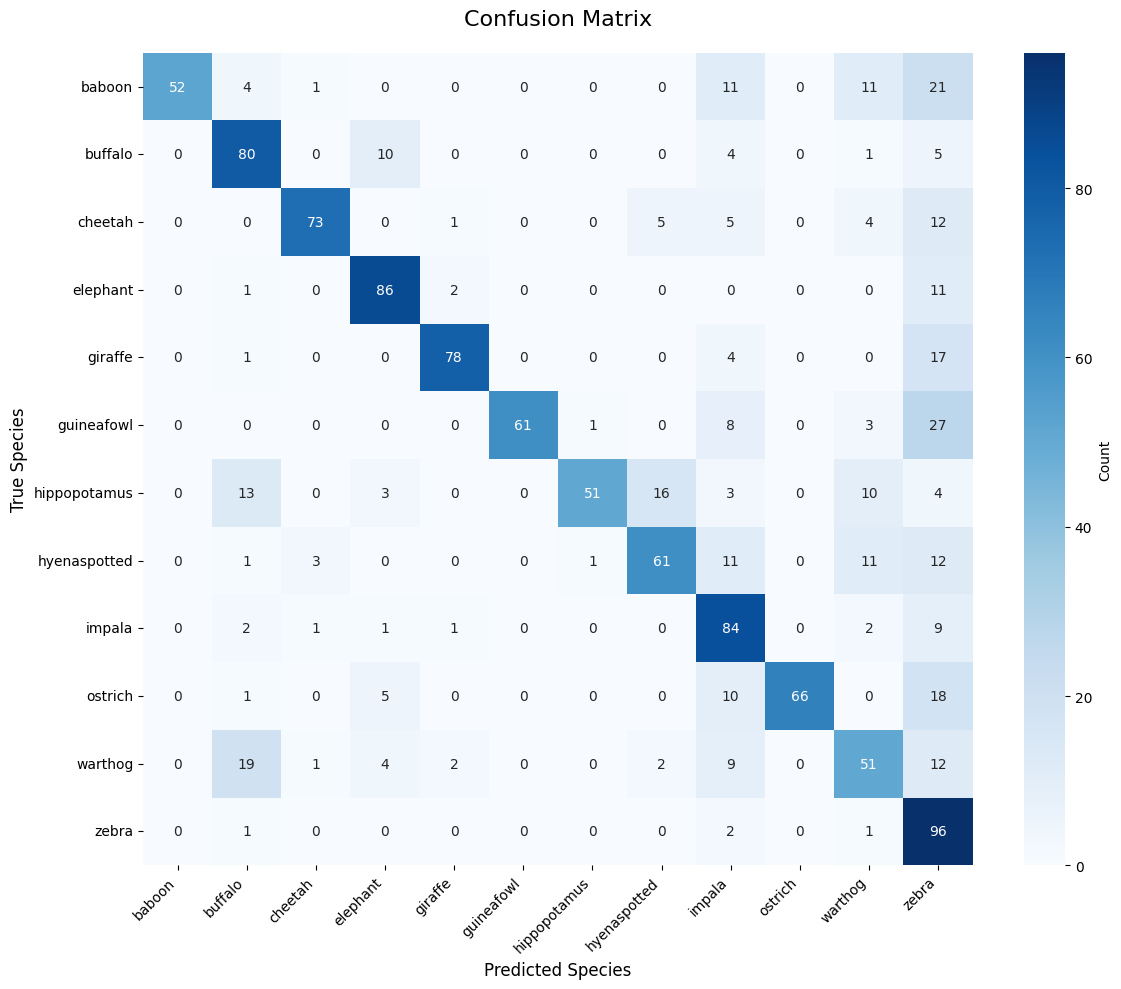

In [5]:
# Calculate all metrics
metrics = calculate_metrics(
    predictions_df=predictions_df,
    save_confusion_matrix=True,
    output_dir="../data"
)

In [6]:
# Display per-class metrics
print("\nDetailed Per-Class Metrics:")
metrics['per_class_metrics']


Detailed Per-Class Metrics:


,Species,Precision,Recall,F1-Score,Support
0,baboon,1.000000,0.52,0.684211,100
1,buffalo,0.650407,0.80,0.717489,100
2,cheetah,0.924051,0.73,0.815642,100
3,elephant,0.788991,0.86,0.822967,100
4,giraffe,0.928571,0.78,0.847826,100
5,guineafowl,1.000000,0.61,0.757764,100
6,hippopotamus,0.962264,0.51,0.666667,100
7,hyenaspotted,0.726190,0.61,0.663043,100
8,impala,0.556291,0.84,0.669323,100
9,ostrich,1.000000,0.66,0.795181,100


In [7]:
# Save metrics summary to file
metrics_summary = {
    'accuracy': float(metrics['accuracy']),
    'precision': float(metrics['precision']),
    'recall': float(metrics['recall']),
    'f1_score': float(metrics['f1_score']),
    'n_samples': int(metrics['n_samples']),
    'n_failed': int(metrics['n_failed'])
}

with open('../data/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)